# Hyperparameter Optimization

That means to find [the best hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_optimization) for the model.
*The best means the best score for given hyperparameters*

There're several options for tuning:
* GridSearch ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) in sklearn)
* [Random Search](https://en.wikipedia.org/wiki/Random_search) ([RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html) in sklearn)

![grid and random tuning](../img/tuning.png)

* [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) (e.g. [hyperopt](https://hyperopt.github.io/hyperopt/))


Let's try to understand the better context and to find where is a pain.

Let's consider hyper parameters for [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_api.html):
- **max_depth** : int, *Maximum tree depth for base learners.*
- **learning_rate** : float, *Boosting learning rate (xgb’s “eta”)*
- **n_estimators** : int, *Number of boosted trees to fit.*
- silent : boolean, *Whether to print messages while running boosting.*
- **objective** : string or callable, *Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).*
- nthread : int, *Number of parallel threads used to run xgboost.*
- **gamma** : float, *Minimum loss reduction required to make a further partition on a leaf node of the tree.*
- **min_child_weight** : int, *Minimum sum of instance weight(hessian) needed in a child.*
max_delta_step : int, *Maximum delta step we allow each tree’s weight estimation to be.*
- **subsample** : float, *Subsample ratio of the training instance.*
- **colsample_bytree** : float, *Subsample ratio of columns when constructing each tree.*
- **colsample_bylevel** : float, *Subsample ratio of columns for each split, in each level.*
- **reg_alpha** : float (xgb’s alpha), *L1 regularization term on weights*
- **reg_lambda** : float (xgb’s lambda), *L2 regularization term on weights*
- scale_pos_weight : float, *Balancing of positive and negative weights.*
- base_score: *The initial prediction score of all instances, global bias.*
- **seed** : int, *Random number seed.*
missing : float, optional, *Value in the data which needs to be present as a missing value. If None, defaults to np.nan.*

There're at least 12 (in **bold**) which could be tuning.
For Grid Case search we should define grid (n - values for each hyperparameter). 

Time needed to compute this:  12 (# hyperparameters) * N (possible values for each) * validation (e.g. k-fold).

Example:
* #hyper_parameters = 12
* #N (values per parameter) = 10
* #cv (k-fold validation) = 3

`12^10 * 3 * time_per_iteration` = a huge number. Even for case `time_per_iteration` is 1s needed ~6000 years :).


And this is why brute-force (grid-search) algorithm failed.

Random search tries do it more optimal, but do it to just simple randomization. That means you don't learn anything from previous steps.

In [1]:
#!pip3 install git+https://github.com/hyperopt/hyperopt

In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
#import helper as h
import gc

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,4)
import seaborn as sns

from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

%matplotlib inline

Let's first relatively simple task to understand better how to use `hyperopt`.

The task find 3 weights: w1, w2 and w3 for given function. We know only sensible range for these weights.

In [3]:
def weigths():
    return 7.65, 12.98, 3.23  #truth weights, looking for by hyperopt

def model(x, w1, w2, w3):
    return np.array(w1*x + w2*x**2 + w3*x**3)

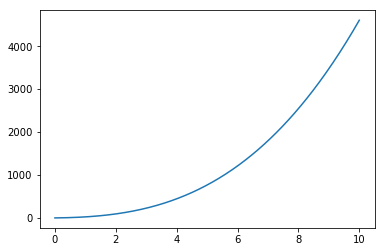

In [4]:
x = np.linspace(0, 10, 500)

w1, w2, w3 = weigths()
y = model(x, *weigths())
plt.plot(x, y);

Let's try find these hyperparameters (w1, w2 and w3) by using hyperopt

iteraions #1: {'x_w1': 7.666980627910412, 'x_w2': 11.246796247167703, 'x_w3': 7.261258986874126}


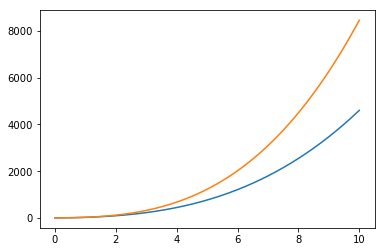

iteraions #5: {'x_w1': 13.505098725949837, 'x_w2': 4.880655982740391, 'x_w3': 3.817027213238164}


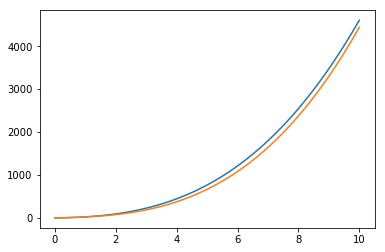

iteraions #10: {'x_w1': 10.22055279716407, 'x_w2': 11.288618087161892, 'x_w3': 3.118983675920448}


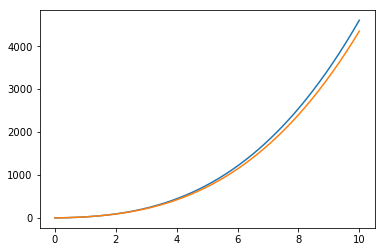

iteraions #50: {'x_w1': 6.797274654425146, 'x_w2': 8.039674982539841, 'x_w3': 3.728633458670827}


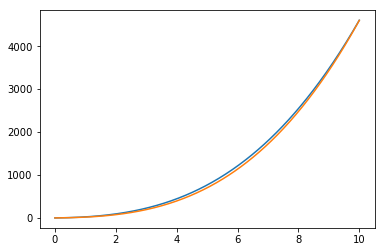

iteraions #100: {'x_w1': 5.3408949935141505, 'x_w2': 11.509806326286656, 'x_w3': 3.549805361286541}


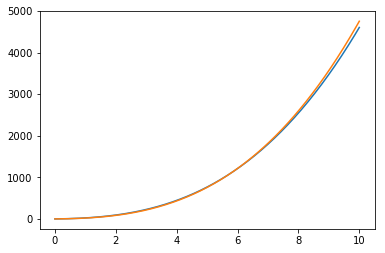

In [5]:
def objective(space):
    pred_value = model(x, space['w1'], space['w2'], space['w3'])
    true_value = model(x, *weigths())
    
    score = np.mean( (pred_value - true_value)**2 )
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'w1': hp.uniform ('x_w1', 0, 15),
    'w2': hp.uniform ('x_w2', 0, 15),
    'w3': hp.uniform ('x_w3', 0, 15)
}
  
for max_evals in [1, 5, 10, 50, 100]:
    trials = Trials()
    best_params = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)
    

    print("iteraions #{0}: {1}".format(max_evals, best_params))
    y_pred = model(x, best_params['x_w1'], best_params['x_w2'], best_params['x_w3'])
    plt.plot(x, y)
    plt.plot(x, y_pred)
    plt.show()

## Let's try optimise more real things
optimize real model with hyperopt

## Links
1. http://hyperopt.github.io/hyperopt/
2. https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt
3. http://fastml.com/optimizing-hyperparams-with-hyperopt/
4. https://github.com/Far0n/xgbfi